## MONICA Crop Model

--------------

Задачи:

* Отрисовать погоду для 2016 и 2017 годов 

* Отрисовать динамику биомассы ✅

* Сделать GA для статьи? 

* Отобразить динамику почвенных условий ✅

* Для всех рядов посчитать метрики

In [1]:
import os, sys
import json
import pandas as pd
import numpy as np 
import datetime as dt
import subprocess
import shutil
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip3 -q install scienceplots


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [55]:
import scienceplots
plt.style.use(['science', 'no-latex'])

# plt.style.use(['science'])


 ## 1. Save weather in proper format for MONICA

In [47]:
def weather_to_monica(src: str, dst: str, 
                      use_real_precip: bool = False,
                      correct_precip:bool=False,
                      use_history:bool=False,
                      reanalysis: str = '../monica/reanalysis.csv'): 
    weather = pd.read_csv(src)
    
    if use_real_precip: 
        era5 = pd.read_csv(reanalysis)
        if len(era5)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = era5.loc[:, 'precip'].copy()
        
    if use_history:
        hist = pd.read_csv('../monica/baseline_monica.csv')
        print('use hist')
        if len(hist)!=len(weather):
            raise ValueError('Size of era5 and forecast should be equal')
        weather.loc[:, 'precip'] = hist.loc[:, 'precip'].copy()
        
        
    weather.loc[:, 'de-date'] = pd.to_datetime(weather['de-date'], format="%d.%m.%Y")
    mask = weather['de-date']<'31.12.2017'
    weather = weather.loc[mask]
    weather['de-date'] = pd.to_datetime(weather['de-date']).dt.strftime('%d.%m.%Y')
    mask = weather['relhumid']>100
    weather.loc[mask, 'relhumid']=99.99
    if correct_precip:
        mask = weather['de-date']>'2017-01-01'
        sum_precip = weather.loc[mask, 'precip'].sum()
        print('sum_precip',sum_precip)
        diff = 633 - sum_precip - 90
        to_add = diff/80
        index_to_add = weather.sample(frac=0.25).index
        weather.loc[index_to_add, 'precip'] = weather.loc[index_to_add, 'precip']+ to_add
        print(weather.iloc[-365:, :]['precip'].sum())
    weather.round(2).to_csv(dst, sep=';', index=False)
    return weather

## 2. Run MONICA model 

In [48]:
def run_monica(climate_fname: str, 
               crop: str = 'sugar-beet',
               kind:str = 'ERA5', 
               use_real_precip:bool=False, 
               correct_precip:bool=False,
              use_history:bool=False)->pd.DataFrame:
    """
    run monica model 
    
    climate_fname: str - path to file with weather
    """
    if crop=='soyabean':
        path_sim_file = '/home/monica/monica_input/soyabean-sim.json'
    elif crop == 'sugar-beet':
        path_sim_file = '/home/monica/monica_input/sugarbeat-sim.json'
    else: 

        raise KeyError(f'crop should be sugar-beet or soyabean, but your is: {crop}')

    path_monica = '../monica/monica_input/'
    dst = os.path.join(path_monica, "climate-monica.csv")
    
    weather = weather_to_monica(src=climate_fname,
                                dst=dst, 
                                use_real_precip=use_real_precip,
                                correct_precip = correct_precip,
                                use_history=use_history)

    weather.loc[:, 'weather'] = kind
    weather['de-date'] = pd.to_datetime(weather['de-date'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y' )))
    cmd = 'monica-run'
    res_monica_run = subprocess.run([cmd, path_sim_file], universal_newlines=True)
    print(res_monica_run)
    daily_monica = pd.read_csv('./out.csv', skiprows=[0,2], skipfooter=30, engine='python')
    daily_monica.loc[:, 'weather'] = kind
    
#     with open('./out.csv', 'r') as file:
#         for i, line in enumerate(file.readlines()):
#             if line == '"crop"\n':
#                 cutline = i
#                 print(i)
#     cutline = cutline+1
#     final_monica = pd.read_csv('./out.csv', skiprows=cutline, skipfooter=13, engine='python')
# #     final_monica.loc[:, 'weather'] = kind
# #     final_monica = final_monica.drop(axis=0, index=0)
#     os.remove('./out.csv')
    return daily_monica, weather

## Запуск модели MONICA для Сои в сезоне 2016

In [49]:
weather_translate = {
                "Наблюдения": "Observed",
                "Среднее":"Mean", 
                "Prophet": "Prophet",
                "Neural-prophet": "Neural-prophet",
                 "SARIMAX": "SARIMAX"}

In [50]:
year = 2016
weather_files = {
                "Наблюдения": f"../monica/reanalysis_{year}.csv",
                "Среднее":f"../monica/means_{year}.csv", 
                "Prophet": f"../monica/prophet_{year}.csv",
                "Neural-prophet": f"../monica/neural_prophet_{year}.csv",
                 "SARIMAX": f"../monica/sarimax_{year}.csv"}

results_df = dict.fromkeys(list(weather_files.keys()))
results_weather = dict.fromkeys(list(weather_files.keys()))

In [51]:
for key in weather_files:
        df, w = run_monica(climate_fname=weather_files[key],
                                          crop='soyabean',
                                          kind=key)
        results_df[key]=df
        results_weather[key]=w
        del df, w

CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/soyabean-sim.json'], returncode=0)


In [52]:
for j, key in enumerate(results_df):
    df = results_df[key].copy() 
    select = df.loc[(df['Date']>'2016-04-01')&(df['Date']<'2016-09-10')]
    print(key, select['Yield'].max())

Наблюдения 3758.6
Среднее 3536.6
Prophet 1964.4
Neural-prophet 3453.3
SARIMAX 3184.2


In [53]:
for j, key in enumerate(results_df):
    df = results_weather[key].copy() 
    select = df.loc[(df['de-date']>'2016-04-01')&(df['de-date']<'2016-09-10')]
    print(key, select['precip'].round(2).sum())

Наблюдения 504.25
Среднее 275.22
Prophet 204.73
Neural-prophet 295.71000000000004
SARIMAX 278.2


In [58]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [60]:
import scienceplots
plt.style.use(['science', 'no-latex'])

In [67]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

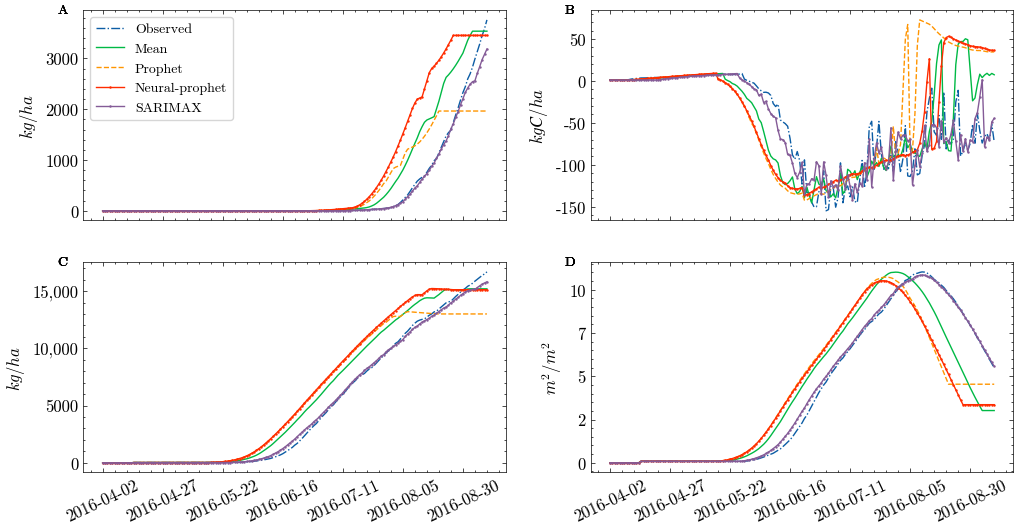

In [69]:
lang = "EN"
variables = ['Yield', 'NEE', 'AbBiom', 'LAI']


names = {'Yield':"Урожай", 'NEE': "NEE", 'AbBiom':"Биомасса", 'LAI': "LAI"}
units = {'Yield':"$Урожайность,\ кг/га$", 'NEE': "$NEE,\ кг С/га$", 
         'AbBiom':"$Надземная\ биомасса,\ кг/га$", 'LAI': "$LAI,\ м^2/м^2$"}


units = {'Yield':"$кг/га$", 'NEE': "$кг С/га$", 
         'AbBiom':"$кг/га$", 'LAI': "$м^2/м^2$"}

styles = ['-.',  '-','--', '.-', '.-', '_']
fig, axes = plt.subplots(2,2,figsize = (12,6))
axes=axes.flatten()
if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Yield':"$kg/ha$", 'NEE': "$kg С/ha$", 
         'AbBiom':"$kg/ha$", 'LAI': "$m^2/m^2$"}

else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Yield':"$кг/га$", 'NEE': "$кг С/га$", 
         'AbBiom':"$кг/га$", 'LAI': "$м^2/м^2$"}

for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
        select = df.loc[(df['Date']>'2016-04-01')&(df['Date']<'2016-09-10')]
        soil = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[soil].plot(style=styles[j],
                                            linewidth=1.0,
                                            ms=1.5, 
                                            label=label_info, 
                                            ax=ax)
#         ax.grid()
        ax.text(-0.05, 1., plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                 transform=ax.transAxes)
        ax.set_xlabel("")
        
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',') if x>9999 else str(int(x))))
        ax.set_ylabel(units[soil])
        if i==0:
            ax.legend(frameon=True)
        if i < 2:

            ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(rotation=25)
plt.savefig(f'../plots/soyabean_crop_{lang}.png', dpi=300)
plt.show()
    

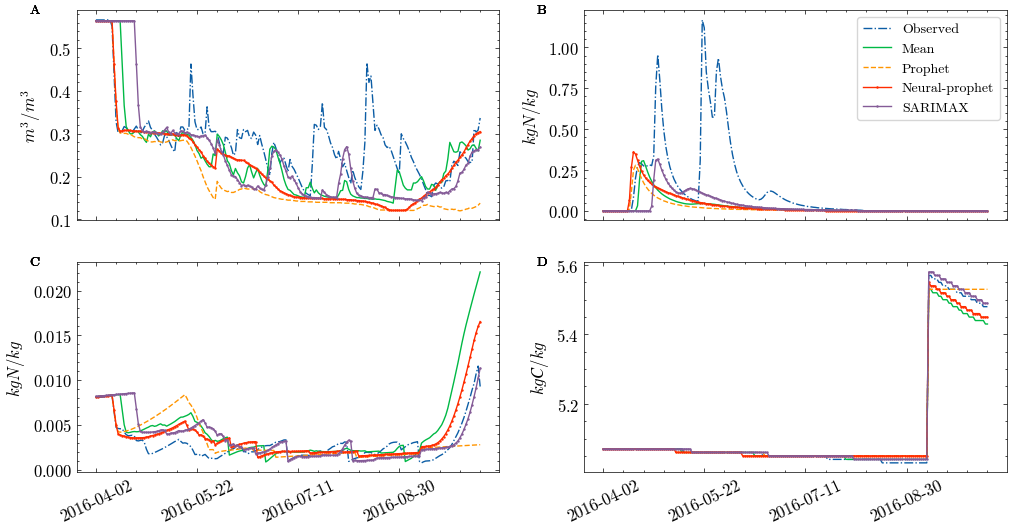

In [70]:
variables = ['Mois_1', 'NLeach', "NO3_1",'SOC_1']

names = {'Mois_1':"Влажность почвы", 'NLeach': "Выщелачивание нитратов", 'NO3_1':"$NO_3$", 'SOC_1': "Орг. вещество"}
units = {'Mois_1':"$m^3/m^3$", 'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 'SOC_1': "$кг С/кг$"}
styles = ['-.',  '-','--', '.-', '.-', '_']
fig, axes = plt.subplots(2,2,figsize = (12,6))

if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Mois_1':"$m^3/m^3$", 'NLeach': "$kg N/kg$",
         'NO3_1':"$kg N/kg$", 'SOC_1': "$kg С/kg$"}
else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Mois_1':"$м^3/м^3$", 'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 'SOC_1': "$кг С/кг$"}
axes=axes.flatten()
for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
        df['SOC_1'] = df['SOC_1'] * 100
        select = df.loc[(df['Date']>'2016-04-01')&(df['Date']<'2016-10-10')]
        soil = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[soil].plot(style=styles[j],
                                            linewidth=1.0,ms=1.5, 
                                            label=label_info, 
                                            ax=ax)
#         ax.grid()
        ax.set_xlabel("")
        ax.set_ylabel(units[soil])
        ax.text(-0.1, 1., plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', transform=ax.transAxes)

        if i==1:
            ax.legend(frameon=True)
        if i < 2:
            ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(rotation=25)
plt.savefig(f'../plots/soyabean_soil_{lang}.png', dpi=300)
plt.show()
    

Погода для сои

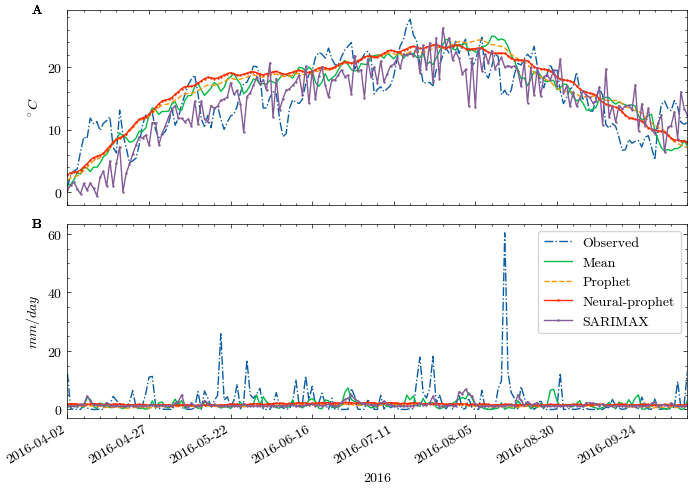

In [99]:
from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%d-%m")


variables = ['Tavg', 'Precip']

names = {'Mois_1':"Влажность почвы", 
         'NLeach': "Выщелачивание нитратов", 
         'NO3_1':"$NO_3$", 
         'SOC_1': "Орг. вещество"}
units = {'Mois_1':"$m^3/m^3$",
         'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 
         'SOC_1': "$кг С/кг$"}

styles = ['-.',  '-','--', '.-', '.-', '_']

fig, axes = plt.subplots(2,1,figsize = (8,6))

if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Precip':"$mm/day$", 
             'Tavg': r"${^\circ}C$",
             'NO3_1':"$kg N/kg$", 
             'SOC_1': "$kg С/kg$"}
else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Mois_1':"$м^3/м^3$", 
             'NLeach': "$кг N/кг$",
            'NO3_1':"$кг N/кг$", 
             'SOC_1': "$кг С/кг$"}

    
axes=axes.flatten()
for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
#         df['SOC_1'] = df['SOC_1'] * 100
        select = df.loc[(df['Date']>'2016-04-01')&(df['Date']<'2016-10-10')]
        weather = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[weather].plot(style=styles[j],
                                            linewidth=1.0,
                                            ms=1.5, 
                                            label=label_info, 
                                            ax=ax)
        ax.set_ylabel(units[weather])
        ax.text(-0.05, 1., plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                transform=ax.transAxes)
        ax.set_xlabel("2016")
        if i==1:
            ax.legend(frameon=True)
        if i==0:
            ax.set_xlabel("")

#             ax.xaxis.set_ticklabels([])
        ax.margins(x=0)
#         ax.xaxis.set_major_formatter(myFmt)
#         ax.xaxis.set_tick_params(rotation=25)
# plt.savefig(f'../plots/soyabean_weather_{lang}.png', dpi=300)
fig.autofmt_xdate()
plt.subplots_adjust(hspace=0.1)
plt.show()

## Сахарная свекла - моделирование и графики

In [71]:
year = 2017
weather_files = {
                "Наблюдения": f"../monica/reanalysis_{year}.csv",
                "Среднее":f"../monica/means_{year}.csv", 
                "Prophet": f"../monica/prophet_{year}.csv",
                "Neural-prophet": f"../monica/neural_prophet_{year}.csv",
                 "SARIMAX": f"../monica/sarimax_{year}.csv"}

results_df = dict.fromkeys(list(weather_files.keys()))
results_weather = dict.fromkeys(list(weather_files.keys()))



In [72]:
for key in weather_files:
        df, w = run_monica(climate_fname=weather_files[key],
                                          crop='sugar-beet',
                                          kind=key)
        results_df[key]=df
        results_weather[key]=w
        del df, w

CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)
CompletedProcess(args=['monica-run', '/home/monica/monica_input/sugarbeat-sim.json'], returncode=0)


In [73]:
for j, key in enumerate(results_df):
    df = results_df[key].copy() 
    select = df.loc[(df['Date']>'2017-04-01')&(df['Date']<'2017-10-19')]
    print(key, select['Yield'].max())

Наблюдения 22261.4
Среднее 29395.6
Prophet 25716.8
Neural-prophet 24187.9
SARIMAX 25045.8


In [74]:
for j, key in enumerate(results_df):
    df = results_weather[key].copy() 
    select = df.loc[(df['de-date']>'2017-04-01')&(df['de-date']<'2017-09-10')]
    print(key, select['precip'].round(2).sum())

Наблюдения 291.87
Среднее 330.66999999999996
Prophet 556.0
Neural-prophet 483.63
SARIMAX 286.91


In [75]:
lang = 'EN'

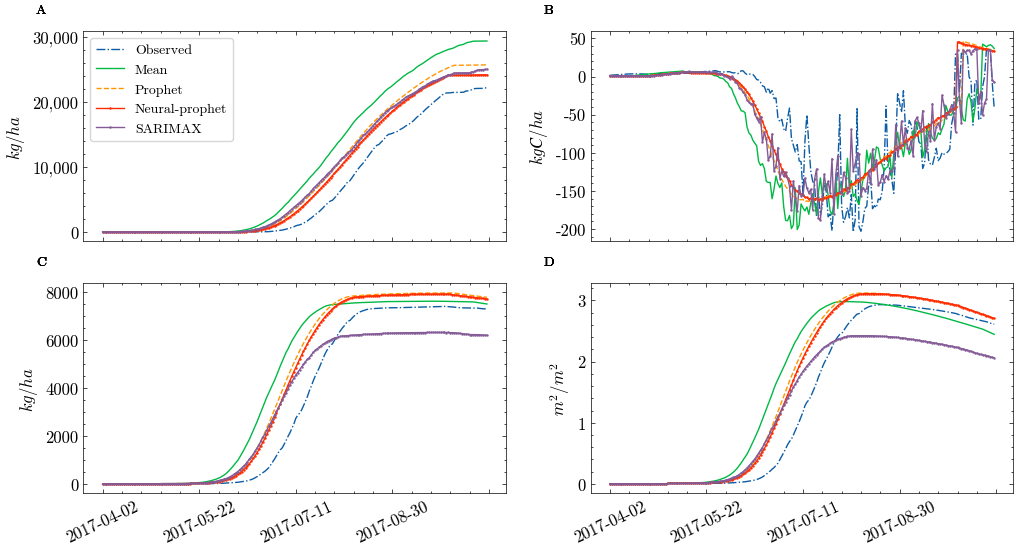

In [76]:
variables = ['Yield', 'NEE', 'AbBiom', 'LAI']


names = {'Yield':"Урожай", 'NEE': "NEE", 'AbBiom':"Биомасса", 'LAI': "LAI"}
units = {'Yield':"$Урожайность,\ кг/га$", 'NEE': "$NEE,\ кг С/га$", 
         'AbBiom':"$Надземная\ биомасса,\ кг/га$", 'LAI': "$LAI,\ м^2/м^2$"}


if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Yield':"$kg/ha$", 'NEE': "$kg С/ha$", 
         'AbBiom':"$kg/ha$", 'LAI': "$m^2/m^2$"}

else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Yield':"$кг/га$", 'NEE': "$кг С/га$", 
         'AbBiom':"$кг/га$", 'LAI': "$м^2/м^2$"}
styles = ['-.',  '-','--', '.-', '.-', '_']
fig, axes = plt.subplots(2,2,figsize = (12,6))
axes=axes.flatten()
for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
        select = df.loc[(df['Date']>'2017-04-01')&(df['Date']<'2017-10-19')]
        soil = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[soil].plot(style=styles[j],
                                            linewidth=1.0,ms=1.5, 
                                            label=label_info, 
                                            ax=ax)

#         ax.grid()
        ax.set_xlabel("")
        ax.set_ylabel(units[soil])
        ax.text(-0.1, 1.1, plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', transform=ax.transAxes)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',') if x>9999 else str(int(x))))

        if i==0:
            ax.legend(frameon=True)
        if i < 2:

            ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(rotation=25)
plt.savefig(f'../plots/sugar-beet_crop_{lang}.png', dpi=300)


plt.show()

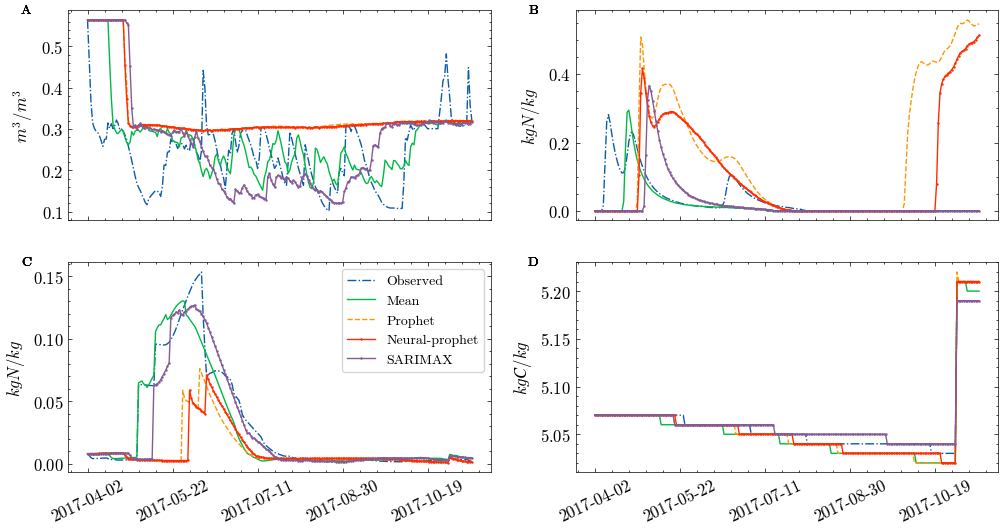

In [77]:
variables = ['Mois_1', 'NLeach', "NO3_1",'SOC_1']

names = {'Mois_1':"Влажность почвы", 'NLeach': "Выщелачивание нитратов", 'NO3_1':"$NO_3$", 'SOC_1': "Орг. вещество"}
units = {'Mois_1':"$Влажность,\  m^3/m^3$", 'NLeach': "$Выщелачивание\ нитратов,$\n$кг N/кг$",
         'NO3_1':"$NO_3$, $кг N/кг$", 'SOC_1': "$Углерод\ орг. вещества,$\n$  кг С/кг$"}
if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Mois_1':"$m^3/m^3$", 'NLeach': "$kg N/kg$",
         'NO3_1':"$kg N/kg$", 'SOC_1': "$kg С/kg$"}
else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Mois_1':"$м^3/м^3$", 'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 'SOC_1': "$кг С/кг$"}

styles = ['-.',  '-','--', '.-', '.-', '_']
fig, axes = plt.subplots(2,2,figsize = (12,6))
axes=axes.flatten()
for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
        df['SOC_1'] = df['SOC_1'] * 100
        select = df.loc[(df['Date']>'2017-04-01')&(df['Date']<'2017-11-15')]
        soil = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[soil].plot(style=styles[j],
                                            linewidth=1.0,ms=1.5, 
                                            label=label_info, 
                                            ax=ax)
#         ax.grid()
        ax.set_xlabel("")
        ax.text(-0.1, 1., plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', transform=ax.transAxes)

        ax.set_ylabel(units[soil])
        if i==2:
            ax.legend(frameon=True)
        if i < 2:
            ax.xaxis.set_ticklabels([])
        ax.xaxis.set_tick_params(rotation=25)
plt.savefig(f'../plots/sugar-beet_soil_{lang}.png', dpi=300)
plt.show()
    

Погода

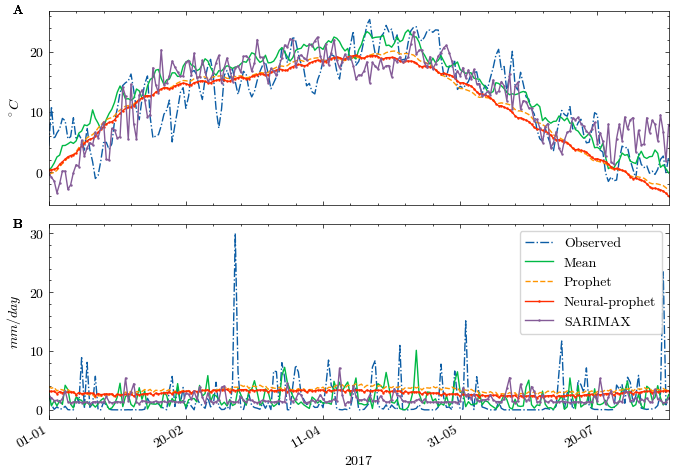

In [92]:
from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%d-%m")


variables = ['Tavg', 'Precip']

names = {'Mois_1':"Влажность почвы", 
         'NLeach': "Выщелачивание нитратов", 
         'NO3_1':"$NO_3$", 
         'SOC_1': "Орг. вещество"}
units = {'Mois_1':"$m^3/m^3$",
         'NLeach': "$кг N/кг$",
         'NO3_1':"$кг N/кг$", 
         'SOC_1': "$кг С/кг$"}

styles = ['-.',  '-','--', '.-', '.-', '_']

fig, axes = plt.subplots(2,1,figsize = (8,6))

if lang == 'EN':
    plot_nums = {0:"A", 1:"B", 2:"C", 3:"D" }
    units = {'Precip':"$mm/day$", 
             'Tavg': r"${^\circ}C$",
             'NO3_1':"$kg N/kg$", 
             'SOC_1': "$kg С/kg$"}
else: 
    plot_nums = {0:"A", 1:"Б", 2:"В", 3:"Г" }
    units = {'Mois_1':"$м^3/м^3$", 
             'NLeach': "$кг N/кг$",
            'NO3_1':"$кг N/кг$", 
             'SOC_1': "$кг С/кг$"}

    
axes=axes.flatten()
for i, ax in enumerate(axes):
    for j, key in enumerate(results_df):
        df = results_df[key].copy() 
#         df['SOC_1'] = df['SOC_1'] * 100
        select = df.loc[(df['Date']>'2017-04-01')&(df['Date']<'2017-11-15')]
        weather = variables[i]
        if lang=='EN':
            label_info = weather_translate[key]
            
        else: 
            label_info = key
        select.set_index('Date')[weather].plot(style=styles[j],
                                            linewidth=1.0,
                                            ms=1.5, 
                                            label=label_info, 
                                            ax=ax)
#         ax.grid()
        
        ax.set_ylabel(units[weather])
        ax.text(-0.05, 1., plot_nums[i], 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                transform=ax.transAxes)
        ax.set_xlabel("2017")
        if i==1:
            ax.legend(frameon=True)
        if i==0:
            ax.set_xlabel("")
#             ax.legend(frameon=True)
#             ax.xaxis.set_ticklabels([])
        ax.margins(x=0)
#         ax.xaxis.set_tick_params(rotation=2)
        ax.xaxis.set_major_formatter(myFmt)

plt.savefig(f'../plots/sugarbeet_weather_{lang}.png', dpi=300)
fig.autofmt_xdate()
plt.subplots_adjust(hspace=0.1)
plt.show()

## Графики

In [16]:
import scienceplots
plt.style.use(['science', 'no-latex'])

In [23]:
sb_monica
nit = ['NLeach',
"NO3_1",
"NO3_2",
"NH4_1",
"NH4_2",
"NO2_1",
"NO2_2"]

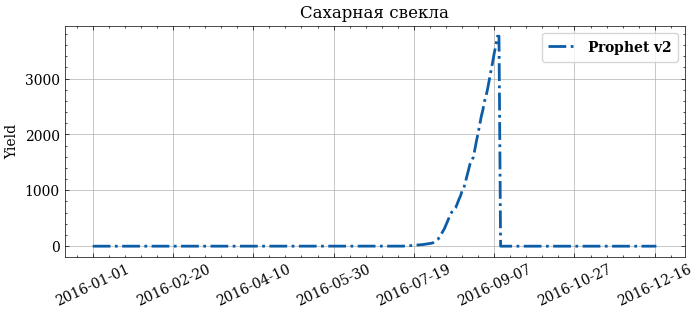

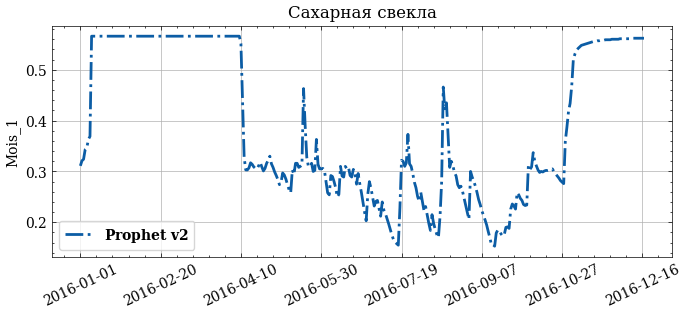

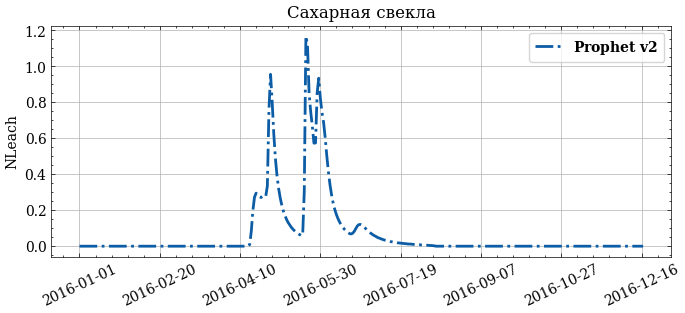

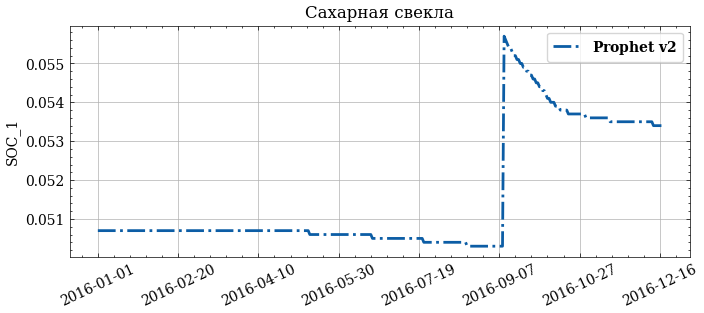

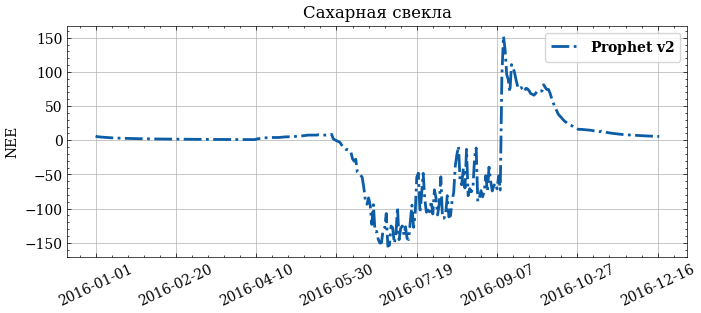

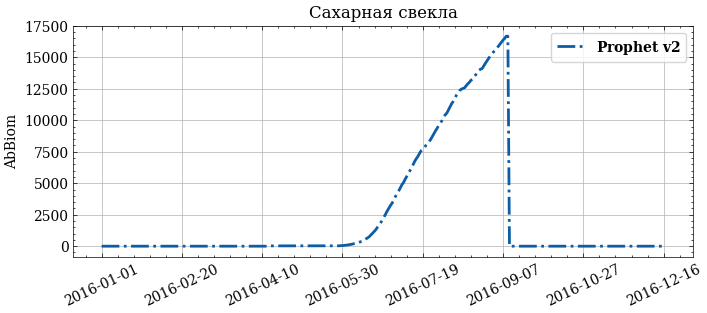

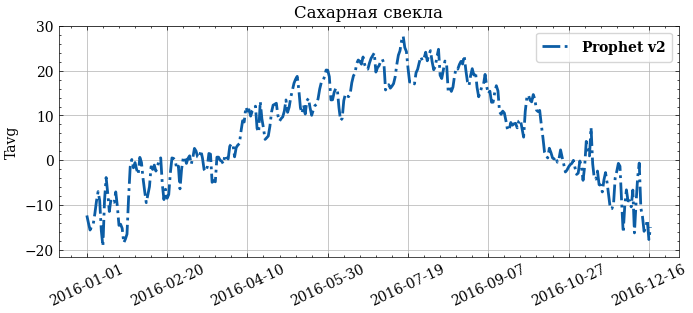

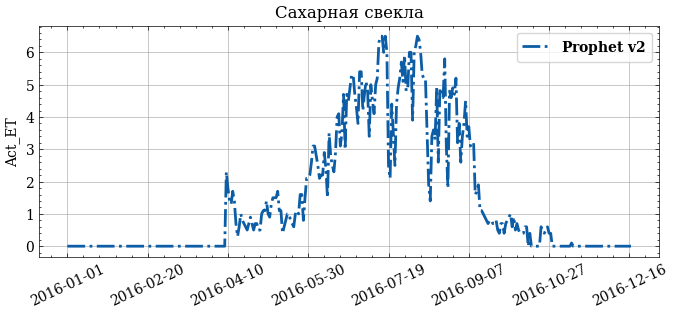

In [29]:
variables = ['Yield', 'Mois_1', 'NLeach', 'SOC_1', 'NEE', 'AbBiom', 'Tavg', 'Act_ET']
['r*-','bo-','y^-']
for i, var in enumerate(variables):
    fig, ax = plt.subplots(1,1,figsize = (8,3))
    soya_monica.set_index('Date')[var].plot(style='-.', linewidth=2.0, label="$\\bf{Prophet\  v2}$", ax=ax)
#     sb_n.set_index('Date')[var].plot(style='-', linewidth=1.5, label='Prophet', ax=ax)
#     sb_baseline.set_index('Date')[var].plot(style='--', linewidth=1.5, label="15-years mean", ax=ax)
#     sb_monica.set_index('Date')[var].plot(style=':',linewidth=1.8,label='Observed (ERA5)', ax=ax)
    plt.ylabel(var)
    ax.legend(frameon=True)
    ax.set_title("Сахарная свекла")
#     ax.set_ylabel("Урожайность, кг/га")
    ax.set_xlabel("")
    plt.xticks(rotation=25)
    plt.grid()
    plt.show()

## Запуск модели MONICA для Сахарной свеклы в сезоне 2017

In [134]:
df_prophet, t_p, w_p = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                       kind='prophet')

df_prophet_corr, t_p_corr, w_p_corr = run_monica(climate_fname='../monica/prediction_monica.csv',
                                       kind='prophet_corr', correct_precip=True)


df_prophet_real, t_p_real, w_p_real = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                       kind='prophet_real_pr', use_real_precip=True)


df_baseline_monica, t_p_baseline, w_p_baseline = run_monica(climate_fname='../monica/baseline_monica.csv', 
                                       kind='baseline_monica')


df_neural_prophet, t_np, w_np = run_monica(climate_fname='../monica/prediction_monica.csv', 
                                                     kind='Prophet+Hist', use_history=True)

df_neural_mp, t_mp, w_mp = run_monica(climate_fname='../monica/multi_prophet-monica.csv', 
                                                     kind='multi_prophet')



df_mean, t_m, w_m = run_monica(climate_fname='../monica/mean_era5.csv', 
                                                     kind='mean')



df_reanalysis, t_era5, w_era = run_monica(climate_fname='../monica/reanalysis.csv',
                                          kind='era5')

sum_precip 503.7831047410271
495.93811662228086
use hist


In [135]:
df = pd.concat([t_p,t_p_baseline, t_era5, t_p_corr])
df

,CM-count,Crop,Yield,sowing,harvest,weather
1,1,soybean/000,3430.6,2016-04-15,2016-09-10,prophet
2,2,sugar beet/,17800.7,2017-05-02,2017-11-01,prophet
1,1,soybean/000,3746.6,2016-04-15,2016-09-10,baseline_monica
2,2,sugar beet/,20872.8,2017-05-02,2017-11-01,baseline_monica
1,1,soybean/000,3909.4,2016-04-15,2016-09-10,era5
2,2,sugar beet/,21886.2,2017-05-02,2017-11-01,era5
1,1,soybean/000,3670.2,2016-04-15,2016-09-10,prophet_corr
2,2,sugar beet/,21747.2,2017-05-02,2017-11-01,prophet_corr


In [169]:
crop = 'sugar beet/' # soybean/000

mask = df_reanalysis['Crop']==crop
sb_era5 = df_reanalysis.loc[mask]

mask = df_neural_prophet['Crop']==crop
sb_np = df_neural_prophet.loc[mask]

mask = df_prophet_corr['Crop']==crop
sb_corr = df_prophet_corr.loc[mask]

mask = df_baseline_monica['Crop']==crop
sb_baseline = df_baseline_monica.loc[mask]

mask = df_prophet['Crop']==crop
sb_n = df_prophet.loc[mask]

mask = df_mean['Crop']==crop
sb_m = df_mean.loc[mask]


mask = df_neural_mp['Crop']==crop
sb_mp = df_neural_mp.loc[mask]

mask = df_prophet_real['Crop']==crop
sb_pr = df_prophet_real.loc[mask]



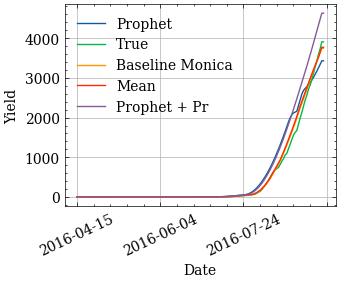

In [137]:
var = 'Yield'
# sb_np.set_index('Date')[var].plot(label='Neural prophet')
sb_n.set_index('Date')[var].plot(label='Prophet')
sb_era5.set_index('Date')[var].plot(label='True')
sb_baseline.set_index('Date')[var].plot(label='Baseline Monica')
sb_m.set_index('Date')[var].plot(label='Mean')
# sb_mp.set_index('Date')[var].plot(label='Multi')
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr')
plt.ylabel(var)
plt.legend()
plt.xticks(rotation=25)
plt.grid()

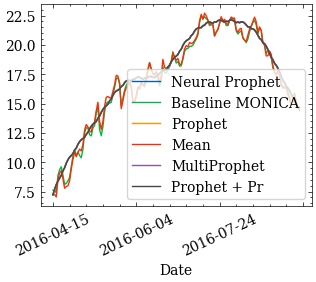

In [138]:
var = 'Tavg'
sb_np.set_index('Date')[var].plot(label='Neural Prophet')
sb_baseline.set_index('Date')[var].plot(label='Baseline MONICA')
sb_n.set_index('Date')[var].plot(label='Prophet')
sb_m.set_index('Date')[var].plot(label='Mean')
sb_mp.set_index('Date')[var].plot(label='MultiProphet')
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr')
plt.legend(frameon=True)
plt.xticks(rotation=25)
plt.show()

## 3. Plots and analytics

In [139]:
!pip -q install SciencePlots


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [140]:
import scienceplots

In [141]:
plt.style.use(['science', 'no-latex'])

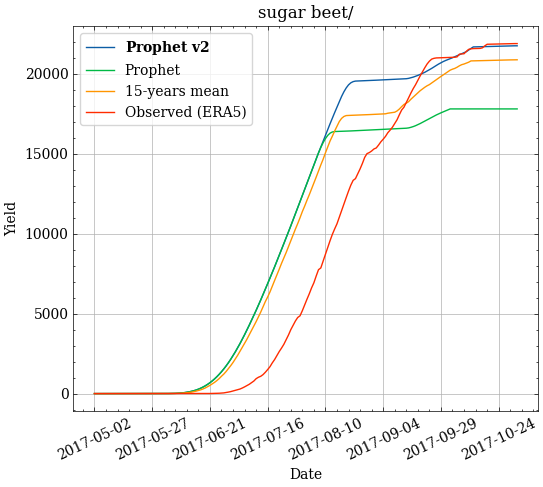

In [170]:
# variables = ['Yield', 'Mois_1', 'SOC_1', 'AbBiom', 'Tavg', 'Act_ET']
# for var in variables:
var = 'Yield'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_corr.set_index('Date')[var].plot(label="$\\bf{Prophet\  v2}$", ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_baseline.set_index('Date')[var].plot(label="15-years mean", ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
# sb_pr.set_index('Date')[var].plot(label='Prophet + Pr',ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title(crop)
plt.xticks(rotation=25)
plt.grid()
plt.show()

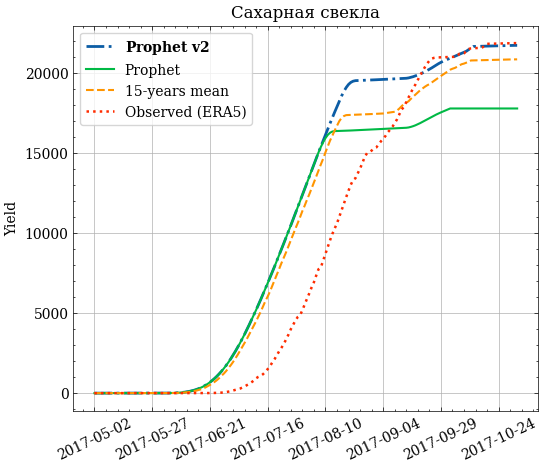

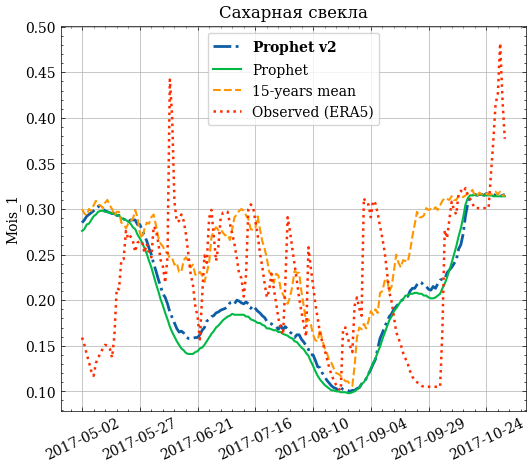

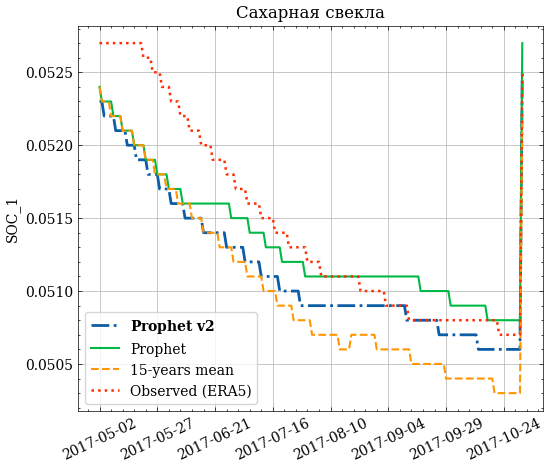

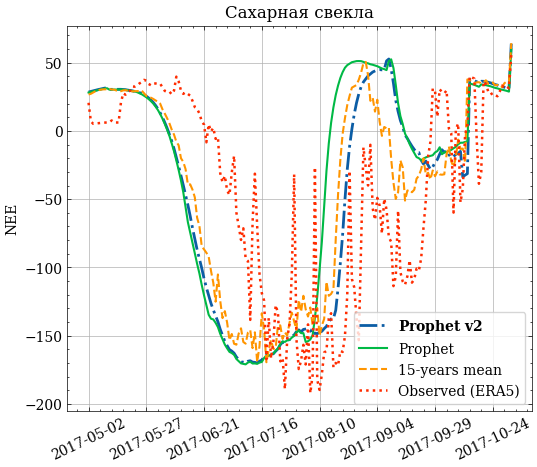

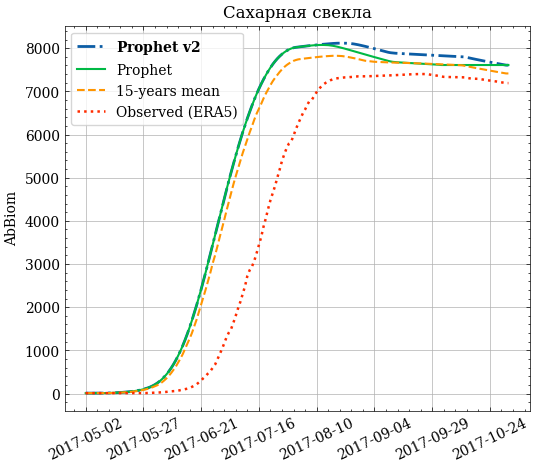

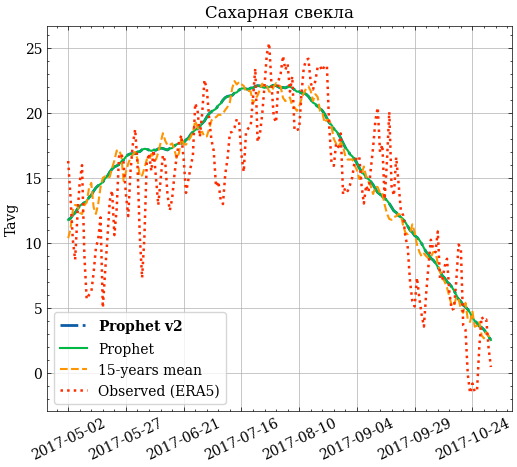

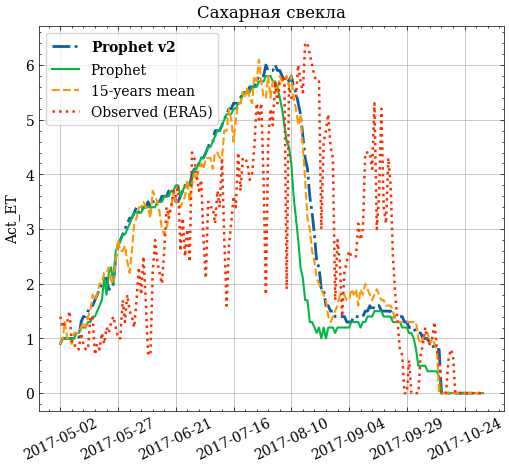

In [191]:
variables = ['Yield', 'Mois_1', 'SOC_1', 'NEE', 'AbBiom', 'Tavg', 'Act_ET']
['r*-','bo-','y^-']
for i, var in enumerate(variables):
    fig, ax = plt.subplots(1,1,figsize = (6,5))
    sb_corr.set_index('Date')[var].plot(style='-.', linewidth=2.0, label="$\\bf{Prophet\  v2}$", ax=ax)
    sb_n.set_index('Date')[var].plot(style='-', linewidth=1.5, label='Prophet', ax=ax)
    sb_baseline.set_index('Date')[var].plot(style='--', linewidth=1.5, label="15-years mean", ax=ax)
    sb_era5.set_index('Date')[var].plot(style=':',linewidth=1.8,label='Observed (ERA5)', ax=ax)
    plt.ylabel(var)
    ax.legend(frameon=True)
    ax.set_title("Сахарная свекла")
#     ax.set_ylabel("Урожайность, кг/га")
    ax.set_xlabel("")
    plt.xticks(rotation=25)
    plt.grid()
    plt.show()

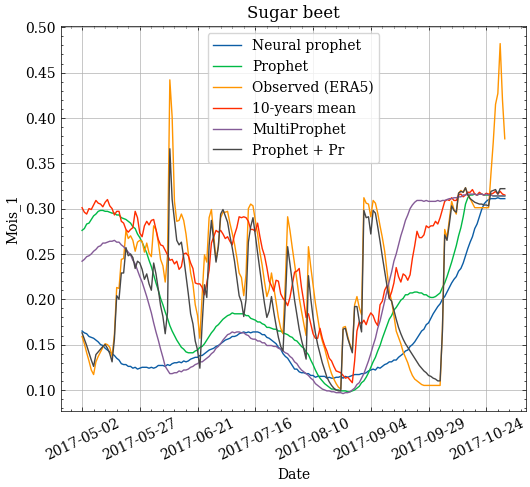

In [148]:


var = 'Mois_1'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
sb_pr.set_index('Date')[var].plot(label='Prophet + Pr',ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [40]:
print(list(sb_era5.columns))

['Date', 'Crop', 'TraDef', 'Tra', 'NDef', 'HeatRed', 'FrostRed', 'OxRed', 'Stage', 'TempSum', 'VernF', 'DaylF', 'IncRoot', 'IncLeaf', 'IncShoot', 'IncFruit', 'RelDev', 'LT50', 'AbBiom', 'OrgBiom/Root', 'OrgBiom/Leaf', 'OrgBiom/Shoot', 'OrgBiom/Fruit', 'Yield', 'GroPhot', 'NetPhot', 'MaintR', 'GrowthR', 'StomRes', 'Height', 'LAI', 'RootDep', 'EffRootDep', 'TotBiomN', 'AbBiomN', 'SumNUp', 'ActNup', 'PotNup', 'NFixed', 'Target', 'CritN', 'AbBiomNc', 'YieldNc', 'Protein', 'NPP', 'NPP/Root', 'NPP/Leaf', 'NPP/Shoot', 'NPP/Fruit', 'GPP', 'Ra', 'Ra/Root', 'Ra/Leaf', 'Ra/Shoot', 'Ra/Fruit', 'Mois_1', 'Mois_2', 'Mois_3', 'Mois_4', 'Mois_5', 'Mois_6', 'Mois_7', 'Mois_8', 'Mois_9', 'Mois_10', 'Mois_11', 'Mois_12', 'Mois_13', 'Mois_14', 'Mois_15', 'Mois_16', 'Mois_17', 'Mois_18', 'Mois_19', 'Mois_20', 'Precip', 'Irrig', 'Infilt', 'Surface', 'RunOff', 'SnowD', 'FrostD', 'ThawD', 'PASW_1', 'PASW_2', 'PASW_3', 'PASW_4', 'PASW_5', 'PASW_6', 'PASW_7', 'PASW_8', 'PASW_9', 'PASW_10', 'PASW_11', 'PASW_12',

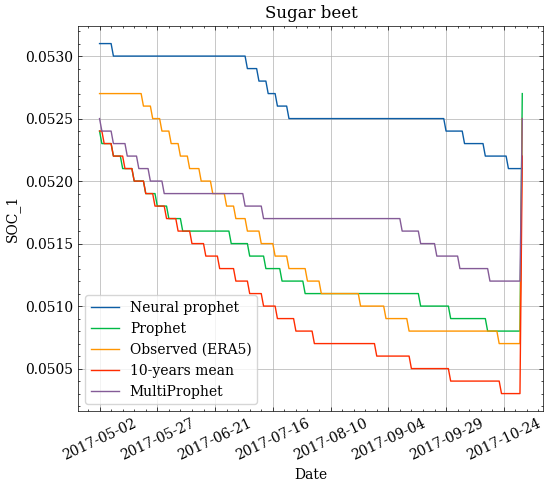

In [41]:


var = 'SOC_1'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

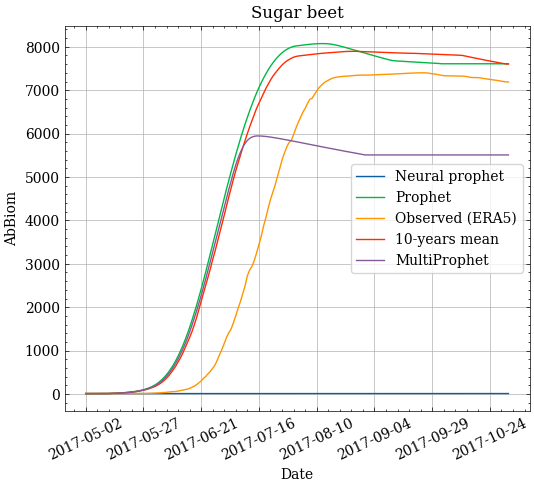

In [42]:


var = 'AbBiom'
fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='Observed (ERA5)', ax=ax)
sb_m.set_index('Date')[var].plot(label='10-years mean', ax=ax)
sb_mp.set_index('Date')[var].plot(label='MultiProphet', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

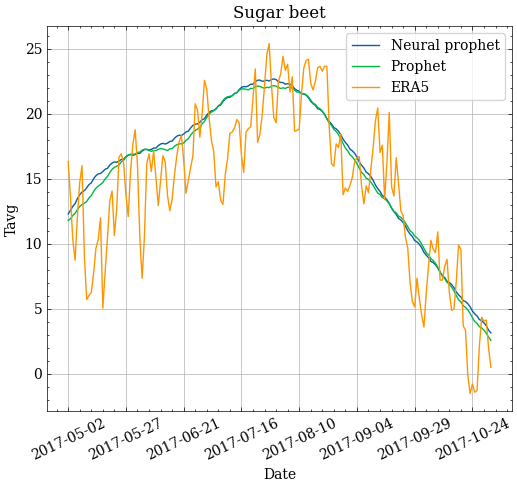

In [43]:
var = 'Tavg'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [44]:
sb_n.columns[-20:]

Index(['CBal_1', 'Nmin_1', 'Nmin_2', 'Nmin_3', 'NetNmin', 'Denit', 'N2O',
       'SoilpH', 'NEP', 'NEE', 'Rh', 'Tmin', 'Tavg', 'Tmax', 'Wind', 'Globrad',
       'Relhumid', 'Sunhours', 'NFert', 'weather'],
      dtype='object')

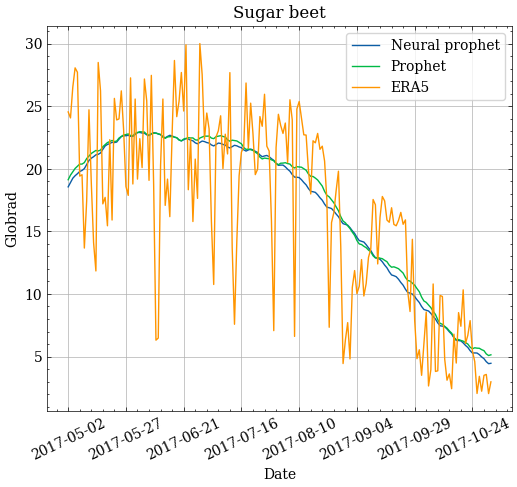

In [45]:
var = 'Globrad'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

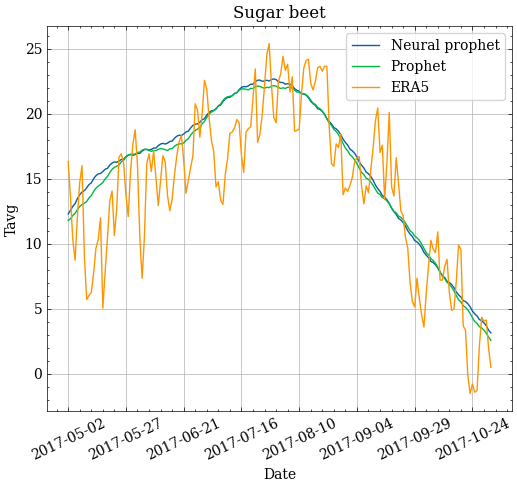

In [46]:
var = 'Tavg'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

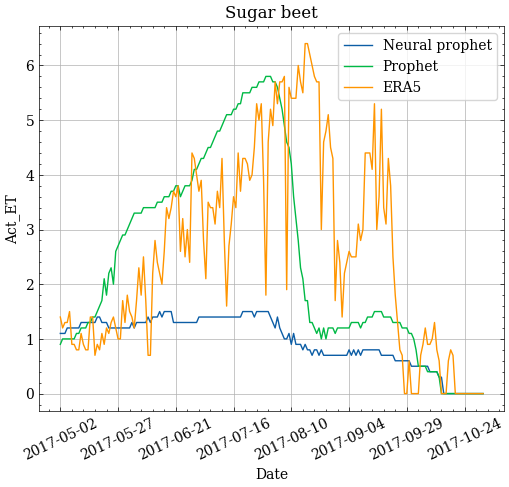

In [47]:
var = 'Act_ET'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

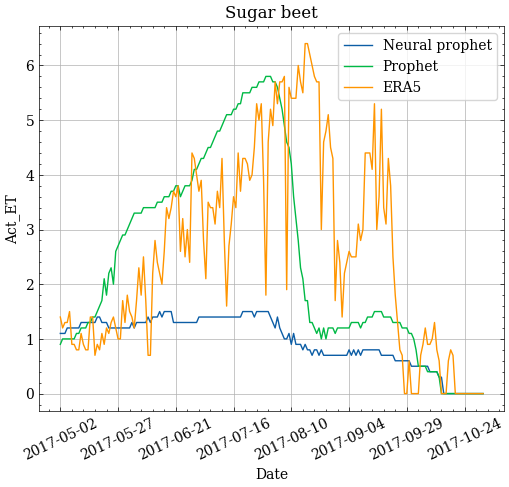

In [48]:
var = 'Act_ET'

fig, ax = plt.subplots(1,1,figsize = (6,5))
sb_np.set_index('Date')[var].plot(label='Neural prophet', ax=ax)
sb_n.set_index('Date')[var].plot(label='Prophet', ax=ax)
sb_era5.set_index('Date')[var].plot(label='ERA5', ax=ax)
plt.ylabel(var)
ax.legend(frameon=True)
ax.set_title('Sugar beet')
plt.xticks(rotation=25)
plt.grid()

In [157]:
df['Yield'] = df['Yield'].astype(float)

In [164]:
crop = 'soybean/000'
mask = df['Crop']==crop
sb = df.loc[mask]

In [165]:
sb.loc[:,'percent_error'] = (sb['Yield'] - sb.loc[sb['weather']=='era5', 'Yield']) / sb['Yield']* 100

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='weather', ylabel='percent_error'>

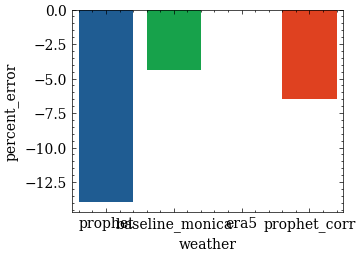

In [166]:
sb

sns.barplot(data=sb, x='weather', y='percent_error')

In [167]:
sb

,CM-count,Crop,Yield,sowing,harvest,weather,percent_error
1,1,soybean/000,3430.6,2016-04-15,2016-09-10,prophet,-13.956742
1,1,soybean/000,3746.6,2016-04-15,2016-09-10,baseline_monica,-4.345273
1,1,soybean/000,3909.4,2016-04-15,2016-09-10,era5,0.000000
1,1,soybean/000,3670.2,2016-04-15,2016-09-10,prophet_corr,-6.517356


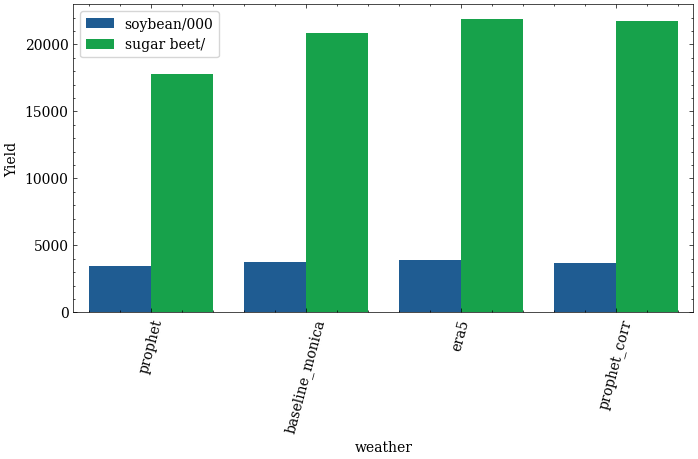

In [168]:
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='weather', y = 'Yield', hue='Crop')
plt.xticks(rotation=75)
plt.legend(frameon=True)
plt.show()

In [55]:
print(w_p.iloc[0:365,:]['precip'].sum())
print(np.sum(w_p.iloc[0:365,:]['precip']*1.2))

517.3336835849038
620.8004203018847


In [200]:
diff = 633 - 456
diff/365
w_p['precip'] = w_p['precip']+(diff/365)

In [60]:
df_w

NameError: name 'df_w' is not defined

In [61]:
df_w = pd.concat([w_p, w_np, w_mp, w_era, w_p_baseline, w_m, w_p_corr])



In [62]:
df_w

,de-date,tavg,tmin,tmax,wind,globrad,precip,relhumid,weather
0,2015-01-01,-7.800053,-11.101513,-4.628647,3.575204,2.958820,1.545466,99.990000,prophet
1,2015-01-02,-7.890605,-11.198918,-4.733343,3.532336,3.093737,1.310682,99.990000,prophet
2,2015-01-03,-7.848884,-11.273822,-4.664492,3.498239,3.149175,1.457735,99.990000,prophet
3,2015-01-04,-7.884629,-11.314735,-4.733464,3.465400,3.226754,1.466637,99.990000,prophet
4,2015-01-05,-8.003344,-11.431237,-4.726967,3.442955,3.142725,1.373366,99.990000,prophet
...,...,...,...,...,...,...,...,...,...
1090,2017-12-26,-7.490335,-10.847686,-3.862259,3.531339,2.619966,1.251262,96.314322,prophet_corr
1091,2017-12-27,-7.608673,-11.003651,-3.974099,3.531001,2.808434,1.727680,96.503170,prophet_corr
1092,2017-12-28,-7.578751,-10.940591,-4.008913,3.598909,2.904380,1.298230,96.193539,prophet_corr
1093,2017-12-29,-7.653896,-11.024546,-4.102131,3.555561,3.013997,1.079899,95.678111,prophet_corr


In [202]:
df_w.groupby('weather').mean().round(2)

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
Prophet+Hist,6.32,1.52,11.33,2.99,12.64,1.74,84.49
baseline_monica,6.01,1.45,10.42,3.05,12.04,1.74,81.77
era5,6.36,1.89,10.67,3.15,11.89,2.02,81.80
mean,6.03,1.46,10.45,3.06,12.10,1.74,81.64
multi_prophet,6.28,1.52,11.29,2.99,12.64,1.35,70.92
prophet,6.32,1.52,11.33,2.99,12.64,1.82,84.49
prophet_corr,6.32,1.52,11.33,2.99,12.64,1.72,84.49


In [167]:
diff = 633 - 456
diff/365

0.4849315068493151

In [64]:
mask = w_m['de-date']>'2017-01-01'
sum_precip = w_m.loc[mask, 'precip'].sum()

In [65]:
mask = df_w['de-date']>'2017-01-01'
df_w.loc[mask].round(2).groupby('weather').sum()

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
Prophet+Hist,2324.45,565.55,4201.70,1081.16,4628.95,633.54,29926.21
baseline_monica,2207.98,549.85,3812.12,1107.67,4386.83,633.54,29655.52
era5,2249.63,632.07,3802.09,1163.88,4349.21,666.18,29839.88
mean,2216.80,553.13,3826.31,1109.58,4409.56,633.67,29606.14
multi_prophet,2309.14,563.74,4182.24,1081.03,4629.47,460.48,24602.68
prophet,2324.45,565.55,4201.70,1081.16,4628.95,456.53,29926.21
prophet_corr,2324.45,565.55,4201.70,1081.16,4628.95,515.58,29926.21


In [68]:
weather_2017

,de-date,tavg,tmin,tmax,wind,globrad,precip,relhumid,weather
732,2017-01-02,-7.787844,-11.261437,-4.263062,3.445843,3.045231,1.257573,97.689713,prophet
733,2017-01-03,-7.953011,-11.421817,-4.377560,3.416754,3.081257,1.338158,98.136622,prophet
734,2017-01-04,-8.104731,-11.607030,-4.514028,3.418800,3.321686,1.165441,97.118593,prophet
735,2017-01-05,-8.116950,-11.582206,-4.580135,3.493572,3.463543,1.317423,98.203730,prophet
736,2017-01-06,-8.241510,-11.711972,-4.710099,3.461530,3.612282,1.066470,98.124320,prophet
...,...,...,...,...,...,...,...,...,...
1090,2017-12-26,-7.490335,-10.847686,-3.862259,3.531339,2.619966,1.251262,96.314322,prophet_corr
1091,2017-12-27,-7.608673,-11.003651,-3.974099,3.531001,2.808434,1.727680,96.503170,prophet_corr
1092,2017-12-28,-7.578751,-10.940591,-4.008913,3.598909,2.904380,1.298230,96.193539,prophet_corr
1093,2017-12-29,-7.653896,-11.024546,-4.102131,3.555561,3.013997,1.079899,95.678111,prophet_corr


In [74]:
weather_2017.weather.unique()

array(['prophet', 'Prophet+Hist', 'multi_prophet', 'era5',
       'baseline_monica', 'mean', 'prophet_corr'], dtype=object)

In [81]:
select = weather_2017.loc[mask].set_index('de-date')
montly = select.groupby(pd.Grouper(freq='M')).mean()

,tavg,tmin,tmax,wind,globrad,precip,relhumid
de-date,,,,,,,
2017-01-31,-10.062667,-13.573000,-6.791333,4.038000,3.948333,1.613333,96.624667
2017-02-28,-7.755714,-11.770357,-4.231071,4.540714,7.594286,0.995000,95.388929
2017-03-31,0.614194,-2.639677,4.081935,3.477097,10.786774,1.358710,87.328065
2017-04-30,6.235667,0.406000,11.625333,3.579000,16.048667,1.201333,79.183000
2017-05-31,12.093871,5.834839,17.576452,2.803226,21.407097,1.111935,74.312258
2017-06-30,15.778000,10.100667,20.341667,2.835000,21.628667,2.951667,76.720667
2017-07-31,18.756774,13.615806,23.473548,2.467419,20.359355,2.246129,74.846452
2017-08-31,20.709677,14.752258,26.581290,2.568710,18.929677,1.131290,64.749355
2017-09-30,14.049333,8.624333,20.327000,2.952667,13.184667,1.014667,67.425000


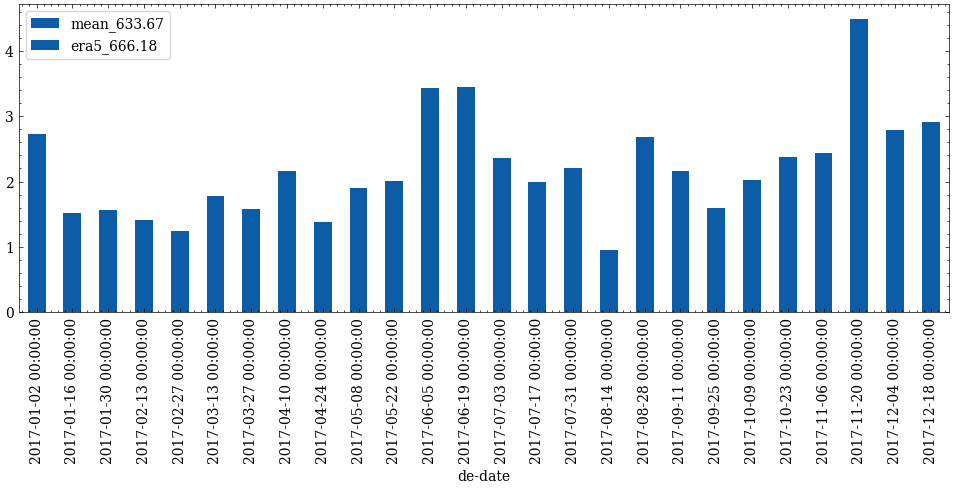

In [85]:
plt.figure(figsize=(12,4))
mask = df_w['de-date']>'2017-01-01'
weather_2017 = df_w.loc[mask]
for kind_weather in ['mean', 'era5']:
    mask = weather_2017['weather']==kind_weather
    sum_pr = weather_2017.loc[mask].set_index('de-date')['precip'].sum()
    select = weather_2017.loc[mask].set_index('de-date')
    montly = select.groupby(pd.Grouper(freq='14D')).mean()
    montly['precip'].plot(kind='bar', label=kind_weather+'_'+str(sum_pr))
#     weather_2017.loc[mask].set_index('de-date')['precip'].plot(label=kind_weather+'_'+str(sum_pr))
    
plt.legend(frameon=True)
plt.show()
    

In [17]:
w_p['precip'].min()

0.540182137326162

In [1]:
df_reanalysis

NameError: name 'df_reanalysis' is not defined

In [11]:
df_w.round(2).groupby('weather').sum() 

,tavg,tmin,tmax,wind,globrad,precip,relhumid
weather,,,,,,,
baseline_monica,6581.50,1590.06,11410.94,3344.83,13182.20,1904.96,89542.47
era5,6965.12,2066.63,11681.07,3452.16,13017.81,2216.00,89574.16
mean,6600.66,1594.02,11444.58,3349.47,13244.04,1909.95,89396.43
multi_prophet,6880.00,1662.41,12364.74,3278.21,13840.40,1474.03,77654.74
neural_prophet,7040.24,1878.18,12271.56,3304.80,13527.67,1008.83,83665.87
prophet,6916.25,1666.77,12408.97,3278.59,13839.12,1464.66,92511.19
